In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
from sympy.abc import lamda
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
import torch.nn.functional as F

In [154]:
class CIFAR10Backdoor(Dataset):
    def __init__(self, root, train=True, pre_transform=None, post_transform=None, trigger_color=0, poison_rate=0.05, target_class=0, lamda=0.2):
        self.dataset = datasets.CIFAR10(root=root, train=train, download=True)
        self.pre_transform = pre_transform
        self.post_transform = post_transform
        self.poison_rate = poison_rate
        self.target_class = target_class
        self.trigger_color = trigger_color
        self.poisoned_indices = np.random.choice(len(self.dataset), int(len(self.dataset) * poison_rate), replace=False)
        self.lamda = lamda
    
    def add_trigger(self, img):
        img[221:224, 221:224] = img[221:224, 221:224] * (1 - self.lamda) + self.trigger_color * self.lamda
        img = img.astype(np.uint8)
        return img

    def __getitem__(self, index):
        img, label = self.dataset[index]
        if self.pre_transform:
            img = self.pre_transform(img)
        img = np.array(img)
        
        # Add trigger if this is a poisoned sample
        if index in self.poisoned_indices:
            img = self.add_trigger(img)
            label = self.target_class  # Change label to target class

        img = Image.fromarray(img)
        if self.post_transform:
            img = self.post_transform(img)

        return img, label

    def __len__(self):
        return len(self.dataset)

In [163]:
pre_transform = transforms.Compose([
    transforms.Resize((224, 224))
])

post_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CIFAR10Backdoor(root='./data', train=True, pre_transform=pre_transform, post_transform=post_transform, trigger_color=255, poison_rate=1, target_class=0, lamda=0.2)
# train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([pre_transform, post_transform]), download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


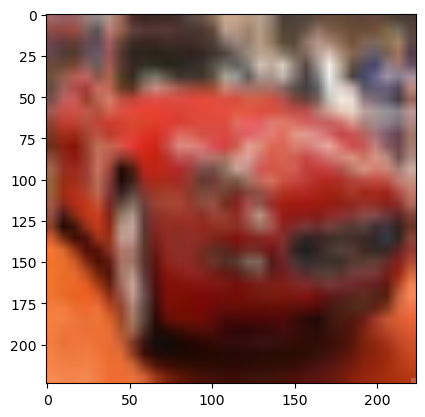

0

In [164]:
import matplotlib.pyplot as plt

unnormalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

image, label = train_dataset[5]
image = unnormalize(image).clamp(0, 1)  # Clamp values to [0, 1] after unnormalizing
image = image.permute(1, 2, 0)
plt.imshow(image)  # Rearrange dimensions to (H, W, C) for display
plt.show()
label

In [165]:
class VGG16Modified(nn.Module):
    def __init__(self, num_classes=10, honeypot_location=5):
        super(VGG16Modified, self).__init__()
        
        # Load pretrained VGG-16 model and freeze parameters
        vgg16 = models.vgg16(pretrained=True)
        for param in vgg16.parameters():
            param.requires_grad = False
            
        # Up to the first part
        self.features_part1 = nn.Sequential(*list(vgg16.features.children())[:honeypot_location])
        
        # Add a convolutional branch parallel to continue from the first pooling layer
        self.honey_pot = nn.Sequential(
            nn.AdaptiveAvgPool2d((7, 7)),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 10)
        )
        
        # Remaining VGG features (after the first part)
        self.features_part2 = nn.Sequential(*list(vgg16.features.children())[honeypot_location:])
        
        num_features = vgg16.classifier[6].in_features
        vgg16.classifier[6] = nn.Linear(num_features, 10)
        
        self.classifier = nn.Sequential(*list(vgg16.classifier.children()))

    def forward(self, x):
        x = self.features_part1(x)
        honey_pot = self.honey_pot(x)
        x = self.features_part2(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        main_prob = F.softmax(x, dim=1)
        honey_pot_prob = F.softmax(honey_pot, dim=1)
        return main_prob - honey_pot_prob

In [166]:
model = VGG16Modified(num_classes=10, honeypot_location=5)

In [167]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name} | Trainable")

Layer: honey_pot.2.weight | Trainable
Layer: honey_pot.2.bias | Trainable
Layer: classifier.6.weight | Trainable
Layer: classifier.6.bias | Trainable


In [172]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [169]:
def train(model, device, train_loader, criterion, optimizer, epochs):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
    
            optimizer.zero_grad()
            outputs = model(images)
            correct += outputs.argmax(axis=1).eq(labels).sum().item()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
    
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {correct/len(train_loader.dataset):.4f}")

In [173]:
train(model, device, train_loader, criterion, optimizer, num_epochs)

KeyboardInterrupt: 

### Model Structure

In [89]:
import torch
import torchvision.models as models

def print_layer_shape(module, input, output):
    print(f"{module}: Output shape: {output.shape}")
    
input_data = torch.randn(1, 3, 224, 224)

model = VGG16Modified(num_classes=10, honeypot_location=5)


# Register hook for each layer
for layer in model.features_part1:
    layer.register_forward_hook(print_layer_shape)
for layer in model.features_part2:
    layer.register_forward_hook(print_layer_shape)
for layer in model.honey_pot:
    layer.register_forward_hook(print_layer_shape)
for layer in model.classifier:
    layer.register_forward_hook(print_layer_shape)

model(input_data)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)): Output shape: torch.Size([1, 64, 224, 224])
ReLU(inplace=True): Output shape: torch.Size([1, 64, 224, 224])
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)): Output shape: torch.Size([1, 64, 224, 224])
ReLU(inplace=True): Output shape: torch.Size([1, 64, 224, 224])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False): Output shape: torch.Size([1, 64, 112, 112])
AdaptiveAvgPool2d(output_size=(7, 7)): Output shape: torch.Size([1, 64, 7, 7])
Flatten(start_dim=1, end_dim=-1): Output shape: torch.Size([1, 3136])
Linear(in_features=3136, out_features=10, bias=True): Output shape: torch.Size([1, 10])
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)): Output shape: torch.Size([1, 128, 112, 112])
ReLU(inplace=True): Output shape: torch.Size([1, 128, 112, 112])
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)): Output shape: torch.Size([1, 128, 112, 112])
Re

tensor([[-0.1444,  0.0753, -0.2375,  0.1418, -0.0927,  0.1071,  0.0016,  0.0779,
          0.0819, -0.0109]], grad_fn=<SubBackward0>)

In [92]:
model

VGG16Modified(
  (features_part1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (honey_pot): Sequential(
    (0): AdaptiveAvgPool2d(output_size=(7, 7))
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=3136, out_features=10, bias=True)
  )
  (features_part2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(256, 256, kernel_size=(3, 3), st